In [6]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.student import Student



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# initialize jax RNG
key = jr.PRNGKey(0)

### General Multivariate Student-t Distribution

In [8]:
dim = 2
deg = 5
M = np.random.normal(0,1, (dim, dim))
mu = np.random.normal(0,1, dim)
cov = M @ M.T
dist = Student(mu=mu, cov=cov, deg=deg)

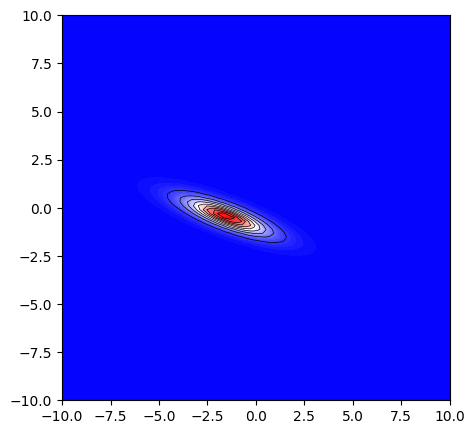

In [9]:
key, key_ = jr.split(key)
n_samples = 100_000
samples = dist.sample(key=key_, n_samples=n_samples)


# plot contour plot of the distribution
xmin, xmax = -10, 10
ymin, ymax = -10, 10
npts = 100
X, Y = np.meshgrid(np.linspace(xmin, xmax, npts), np.linspace(ymin, ymax, npts), indexing='ij')
X_flat = X.ravel()
Y_flat = Y.ravel()
XY = jnp.stack([X_flat, Y_flat], axis=-1)
Z_flat = dist.batch(XY)
Z = Z_flat.reshape(X.shape)

plt.figure(figsize=(5,5))
# plot contour plot of the distribution with levels in black
plt.contour(X, Y, jnp.exp(Z), levels=10, colors='k', linewidths=0.5)
plt.contourf(X, Y, jnp.exp(Z), levels=50, cmap='bwr')




Empirical mean: [-1.5068039 -0.4500842]
Theoretical mean: [-1.50563056 -0.44971384]
Empirical cov: 
 [[ 3.4195623  -1.199442  ]
 [-1.199442    0.65911597]]
Theoretical cov: 
 [[ 3.42630588 -1.20615112]
 [-1.20615112  0.66006428]]


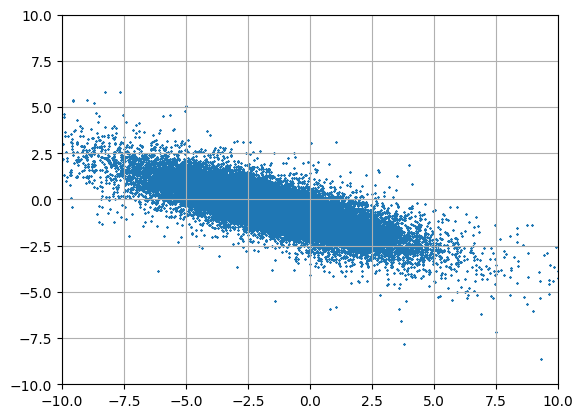

In [10]:
# plot scatter plot of samples
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.scatter(samples[:, 0], samples[:, 1], s=1, marker='x')
plt.grid()

# empirical mean and variance
mean = jnp.mean(samples, axis=0)
# covariance matrix
C = jnp.cov(samples.T)
print(f"Empirical mean: {mean}")
print(f"Theoretical mean: {mu}")
print(f"Empirical cov: \n {C}")
cov_theoretical = cov * dist.deg / (dist.deg - 2)
print(f"Theoretical cov: \n {cov_theoretical}")